# UTS Proyek Sains Data "Prediksi Produksi Listrik"

*   Nama : Rizqiya Ivada
*   Nim : 220411100090
*   Kelas : Proyek Sains Data (D)





# Data Understanding

Data yang digunakan berdasarkan data yang diperoleh dari website kaggle berupa data produksi listrik, berikut untuk link data yang digunakan: [link kaggle](https:///www.kaggle.com/datasets/shenba/time-series-datasets?resource=download). Dalam data tersebut terdapat 2 fitur yaitu DATE yang menunjukkan tanggal produksi listrik yang diamati, dan juga IPG2211A2N sebagai fitur untuk menunjukkan produksi listrik yang diamati. Dataset ini terdiri dari 397 data yang diamati sejak tahun 1985. Untuk proses pengamatan yang dilakukan yaitu dilakukan per tanggal 1 disetiap bulan pada tahun tersebut.

## Menampilkan data

Sebelum menampilkan data, kita perlu melakukan import library yang akan diperlukan dan digunakan selama melakukan pemrosesan data nantinya.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler #new
from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings

Setelah melakukan import library yang diperlukan selanjutnya, code dibawah ini digunakna untuk menampilkan data dlaam file dengan format csv.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PSD/Electric_Production.csv')
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


# Data PreProcessing

## Deskripsi Dataset

*   **Count** digunakan untuk menunjukkan jumlah data yang ada di dalam dataset
*   **Mean** digunakan untuk menunjukkan nilai rata-rata dari data yang ada
*  **Min dan Max** digunakan untuk menunjukkan nilai minimal dan nilai maksimal dari data-data tersebut.
*   **25%**: Kuartil pertama (Q1) digunakan untuk menunjukkan 25% dari nilai berada di bawah angka yang tertera.
*   **50% (median)**: Median (nilai tengah) digunakan untuk menunjukkan bahwa 50% dari data memiliki nilai lebih kecil dari nilai yang tertera dan 50% lainnya lebih besar.
*   **75%: Kuartil ketiga (Q3)** digunakan untuk menunjukkan 75% dari nilai berada di bawah angka yang tertera.
*   **Std (standar deviasi)** digunakan untuk menunjukkan seberapa tersebar nilai-nilai dalam data dari rata-ratanya. Semakin tinggi standar deviasi, semakin bervariasi atau menyebar data.


In [ ]:
description = df.describe()
print(description)

       IPG2211A2N
count  397.000000
mean    88.847218
std     15.387834
min     55.315100
25%     77.105200
50%     89.779500
75%    100.524400
max    129.404800


## Missing Value

Code dibawah ini digunakan untuk mengecek apakah didalam dataset yang digunakan terdapat missing value atau tidak. Setelah di cek menggunakan code dibawah, pada dataset ini tidak memiliki missing value didalamnya.

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

DATE          0
IPG2211A2N    0
dtype: int64


## Mengkonversi format DATE

Code dibawah digunakan untuk mengkonversi format fitur DATE menjadi datetime

In [ ]:
# Mengonversi 'transaction_date' ke format datetime
df['DATE'] = pd.to_datetime(df['DATE'])
df
df.set_index('DATE', inplace=True)
df

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


##Menambahkan fitur month

Penambahan fitur month disini digunakan untuk melakukan perhitungan di setiap bulan pada periode selanjutnya dengan menggunakan pendekatan supervised learning menggunakan teknik sliding window

In [ ]:
# We'll use a supervised learning approach: predicting the next value based on previous values
df['Month'] = np.arange(1,len(df)+1)  # Adding a month counter
df

,IPG2211A2N,Month
DATE,,
1985-01-01,72.5052,1
1985-02-01,70.6720,2
1985-03-01,62.4502,3
1985-04-01,57.4714,4
1985-05-01,55.3151,5
...,...,...
2017-09-01,98.6154,393
2017-10-01,93.6137,394
2017-11-01,97.3359,395


# Modelling

## Bagging

### Membagi Data

Sliding window bekerja dengan cara mengambil sejumlah data dari masa lalu (disebut "window" atau "jendela") dan menggunakan data tersebut sebagai input untuk memprediksi nilai masa depan. Setiap kali jendela bergeser, data yang paling lama di dalam jendela akan diganti dengan data baru dari deret waktu.

---

Code dibawah menunjukkan bahwa fitur yang akan digunakan yaitu fitur month dan target yang akan digunakan yaitu IPG2211A2N. dimana size window yang digunakan sebanyak 12 karena kita akan memprediksi tingkat produksi pada 12 bulan pada periode selanjutnya.

In [ ]:
# Features (Months), Target (IPN31152N)
X = df[['Month']]
y = df['IPG2211A2N']

# Creating a sliding window function to generate features based on previous months
def create_sliding_window_features(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i])
        y.append(df[i])
    return np.array(X), np.array(y)

# Set window size to 12 months (can be adjusted)
window_size = 12

# Creating sliding window features for the target variable
X_window, y_window = create_sliding_window_features(df['IPG2211A2N'].values, window_size)
# print("Shape of X_window:", X_window.shape)

# ==== menampilkan hasil x dan y window
# Membuat dataframe
columns = [f'Bulan-{i}' for i in range(window_size, 0, -1)]  # Nama kolom untuk 12 bulan sebelumnya
df_window = pd.DataFrame(X_window, columns=columns)  # Data 12 bulan sebelumnya
df_window['Target'] = y_window  # Kolom target

# Menampilkan dataframe
df_window


,Bulan-12,Bulan-11,Bulan-10,Bulan-9,Bulan-8,Bulan-7,Bulan-6,Bulan-5,Bulan-4,Bulan-3,Bulan-2,Bulan-1,Target
0,72.5052,70.6720,62.4502,57.4714,55.3151,58.0904,62.6202,63.2485,60.5846,56.3154,58.0005,68.7145,73.3057
1,70.6720,62.4502,57.4714,55.3151,58.0904,62.6202,63.2485,60.5846,56.3154,58.0005,68.7145,73.3057,67.9869
2,62.4502,57.4714,55.3151,58.0904,62.6202,63.2485,60.5846,56.3154,58.0005,68.7145,73.3057,67.9869,62.2221
3,57.4714,55.3151,58.0904,62.6202,63.2485,60.5846,56.3154,58.0005,68.7145,73.3057,67.9869,62.2221,57.0329
4,55.3151,58.0904,62.6202,63.2485,60.5846,56.3154,58.0005,68.7145,73.3057,67.9869,62.2221,57.0329,55.8137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,102.7637,91.4867,92.8900,112.7694,114.8505,99.4901,101.0396,88.3530,92.0805,102.1532,112.1538,108.9312,98.6154
381,91.4867,92.8900,112.7694,114.8505,99.4901,101.0396,88.3530,92.0805,102.1532,112.1538,108.9312,98.6154,93.6137
382,92.8900,112.7694,114.8505,99.4901,101.0396,88.3530,92.0805,102.1532,112.1538,108.9312,98.6154,93.6137,97.3359
383,112.7694,114.8505,99.4901,101.0396,88.3530,92.0805,102.1532,112.1538,108.9312,98.6154,93.6137,97.3359,114.7212


###Standarisasi Dataset

Code dibawah digunakan untuk membagi data yang akan digunakan untuk proses modelling selanjutnya. Dimana data dibagi menjadi data testing dan juga data training. Banyak data yang digunakan untuk data testing sebanyak 20% dan banyak data yang digunakan untuk data training yaitu 80%. Setelah dilakukan pembagian data, selanjutnya dilakukan proses standarisasi data dengan menggunakan standard scaller sehingga memiliki mean 0 dan standard deviation 1.

In [ ]:
# Splitting the df into training and test sets
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_window, y_window, test_size=0.2, shuffle=False)

# Scaling features
scaler = StandardScaler()
X_train_w_scaled = scaler.fit_transform(X_train_w)
X_test_w_scaled = scaler.transform(X_test_w)

### Membangun model bagging

Code dibawah digunakan untuk membangun model yang akan digunakan untuk melakkukan prediksi. Pada percobaan kali ini, kita akan menggunakan 3 base model untuk melakukan prediksi yaitu (decision tree, random forest, dan juga linear regression). Untuk mendapatkan rata-rata dari 3 base model yang digunakan, maka diperlukan voting regressor, nantinya hasil dari voting regressor akan menampilkan rata-rata prediksi dari 3 base model yang digunakan

In [ ]:
# Define the three base models
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
linear_model = LinearRegression()

# Create a VotingRegressor (acts as the combination of 3 base models)
voting_regressor = VotingRegressor(estimators=[('tree', tree_model), ('forest', forest_model), ('linear', linear_model)])

# Build the Bagging Regressor with the VotingRegressor as the base model
bagging_model_voting = BaggingRegressor(estimator=voting_regressor, n_estimators=100, random_state=42)
bagging_model_voting.fit(X_train_w_scaled, y_train_w)

# Predicting on the test set
y_pred_voting = bagging_model_voting.predict(X_test_w_scaled)

# Calculate performance metrics
rmse_voting = np.sqrt(mean_squared_error(y_test_w, y_pred_voting))
mse_voting = mean_squared_error(y_test_w, y_pred_voting)
mae_voting = mean_absolute_error(y_test_w, y_pred_voting)
r2_voting = r2_score(y_test_w, y_pred_voting)
mape_voting = mean_absolute_percentage_error(y_test_w, y_pred_voting)

# Predicting the next 12 months using the ensemble sliding window
last_window = df['IPG2211A2N'].values[-window_size:]
predictions_voting = []
for _ in range(12):
    last_window_scaled = scaler.transform(last_window.reshape(1, -1))
    next_pred = bagging_model_voting.predict(last_window_scaled)
    predictions_voting.append(next_pred[0])
    # Update the window with the new prediction
    last_window = np.append(last_window[1:], next_pred)

### Visualisasi bagging

Code dibawah ini digunakan untuk menampilkan hasil prediksi yang sudah menggunakan 3 base model sebelumnya.

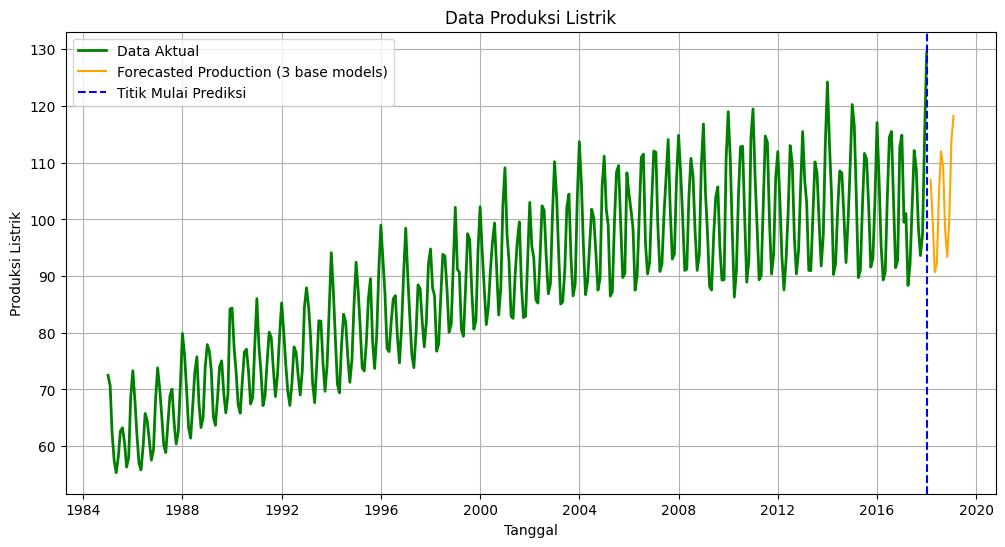

In [ ]:
# Pastikan df sudah berisi data yang sesuai
plt.figure(figsize=(12, 6))

# Plot data aktual
plt.plot(df.index, df['IPG2211A2N'], label='Data Aktual', color='green', linewidth=2)
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], predictions_voting, label='Forecasted Production (3 base models)', color='orange')
# Garis vertikal untuk menunjukkan transisi antara data aktual dan prediksi
plt.axvline(x=df.index[-1], color='blue', linestyle='--', label='Titik Mulai Prediksi')# Menambahkan judul, label, dan legenda
plt.title('Data Produksi Listrik')
plt.xlabel('Tanggal')
plt.ylabel('Produksi Listrik')
plt.legend()
plt.grid()

# Menampilkan grafik
plt.show()

Menampilkan data dalam bentuk angka

In [ ]:
# import pandas as pd

# Asumsikan hasil prediksi disimpan dalam list 'predictions_voting'
# Buat range waktu (misalnya untuk 12 bulan ke depan) sebagai index
date_range = pd.date_range(start='2018-01-01', periods=12, freq='MS')

# Buat DataFrame dari prediksi
df_predictions = pd.DataFrame({'Predicted Values': predictions_voting}, index=date_range)

# Tampilkan DataFrame
print(df_predictions)

            Predicted Values
2018-01-01        106.942780
2018-02-01         99.686723
2018-03-01         90.692916
2018-04-01         92.245455
2018-05-01        104.376894
2018-06-01        112.007060
2018-07-01        109.284999
2018-08-01         98.088104
2018-09-01         93.360484
2018-10-01        100.087129
2018-11-01        113.846373
2018-12-01        118.248623


Implementasi jika input data baru

In [ ]:
import pandas as pd

# Misalkan data baru berupa array atau list, contoh:
new_data =np.array([[91.4867,	92.8900,	112.7694,	114.8505,	99.4901,	101.0396,	88.3530,	92.0805,	102.1532,	112.1538,	108.9312,	98.6154]])

# Pastikan untuk melakukan scaling data baru menggunakan scaler yang sudah dipakai
new_data_scaled = scaler.transform(new_data)

# Prediksi menggunakan model yang sudah dilatih
new_predictions = bagging_model_voting.predict(new_data_scaled)

# Buat range waktu untuk data baru, misalnya jika data baru adalah untuk 6 bulan ke depan
new_date_range = pd.date_range(start='2019-01-01', periods=len(new_predictions), freq='MS')

# Buat DataFrame dari prediksi baru
df_new_predictions = pd.DataFrame({'Predicted Values': new_predictions}, index=new_date_range)

# Gabungkan prediksi baru dengan prediksi lama (opsional, jika ingin menyatukan semua prediksi)
df_all_predictions = pd.concat([df_predictions, df_new_predictions])

# Tampilkan DataFrame hasil inputasi baru
print(df_all_predictions)

            Predicted Values
2018-01-01        106.942780
2018-02-01         99.686723
2018-03-01         90.692916
2018-04-01         92.245455
2018-05-01        104.376894
2018-06-01        112.007060
2018-07-01        109.284999
2018-08-01         98.088104
2018-09-01         93.360484
2018-10-01        100.087129
2018-11-01        113.846373
2018-12-01        118.248623
2019-01-01         91.946274


Code dibawah digunakan untuk menampilkan nilai RMSE, MSE, MAE, dan R^2(R Squared)

*   RMSE adalah akar kuadrat dari Mean Squared Error (MSE). Ini mengukur rata-rata kesalahan prediksi dari model dalam satuan yang sama dengan data aslinya (dalam hal ini, satuan produksi es krim).
*   MSE mengukur rata-rata kesalahan kuadrat antara nilai yang diprediksi dan nilai aktual. MSE sering digunakan sebagai ukuran dasar performa model, namun memiliki kelemahan karena hasilnya dalam satuan yang dikuadratkan.
*   MAE mengukur rata-rata kesalahan absolut antara nilai yang diprediksi dan nilai aktual. Berbeda dengan MSE yang mengkuadratkan kesalahan, MAE hanya mengambil nilai absolutnya. MAE memberikan gambaran yang lebih langsung tentang seberapa besar kesalahan dalam prediksi, tanpa memperbesar dampak dari outlier.
*   R² (R-squared) adalah koefisien determinasi yang mengukur seberapa baik model regresi dalam menjelaskan variabilitas data target (y) berdasarkan variabel input (X).





In [ ]:
# rmse_voting, mse_voting, mae_voting, r2_voting, predictions_voting
print("RMSE:", rmse_voting)
print("MSE:", mse_voting)
print("MAE:", mae_voting)
print("R^2 Score:", r2_voting)
print("MAPE:", mape_voting)

RMSE: 3.773084828384363
MSE: 14.23616912218426
MAE: 2.6639285287797287
R^2 Score: 0.8445098170524924
MAPE: 0.025225646555065775


## Arima

ARIMA bekerja dengan memodelkan hubungan antara observasi di masa lalu dan menggabungkan tiga komponen utama: Autoregression (AR), Differencing (I), dan Moving Average (MA). Setiap komponen menangani aspek tertentu dari pola dalam data deret waktu.

Code dibawah digunakan untuk melakukan prediksi dengan menggunakan metode arima dimana 3 komponen utama yang digunakan dimasukkan dalam variabel order=(5, 1, 0) yang merupakan parameter (p, d, q) dari ARIMA

*   p=5: Bagian autoregressive (AR), menunjukkan bahwa model menggunakan 5 lag dari observasi sebelumnya (yaitu, produksi 5 bulan terakhir) untuk memprediksi nilai saat ini.

*   d=1: Bagian differencing (I), menunjukkan bahwa data differencing dilakukan sekali untuk menghilangkan tren atau membuat data stasioner. Ini berarti model menggunakan perbedaan antara nilai saat ini dan nilai bulan sebelumnya.

*   q=0: Bagian moving average (MA), menunjukkan bahwa model tidak menggunakan residual kesalahan dari prediksi sebelumnya.

In [ ]:
# Fit ARIMA model
model_arima = ARIMA(df['IPG2211A2N'], order=(5, 1, 0))  # Sesuaikan order (p, d, q)
model_arima_fit = model_arima.fit()

# Forecast untuk 12 bulan ke depan
forecast_arima = model_arima_fit.forecast(steps=12)

# Hitung metrik untuk ARIMA
y_test_arima = df['IPG2211A2N'].values[-12:]  # Ambil data aktual untuk 12 bulan terakhir
rmse_arima = np.sqrt(mean_squared_error(y_test_arima, forecast_arima))
mse_arima = mean_squared_error(y_test_arima, forecast_arima)
mae_arima = mean_absolute_error(y_test_arima, forecast_arima)
r2_arima = r2_score(y_test_arima, forecast_arima)
mape_arima = mean_absolute_percentage_error(y_test_arima, forecast_arima)

# Membuat tanggal untuk prediksi (lanjutan dari data aktual terakhir)
future_dates_arima = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-19-4f07b80bc98b>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates_arima = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


Code dibawah ini digunakan untuk memvisuallisasikan hasil prediksi dengan menggunakan metode arima

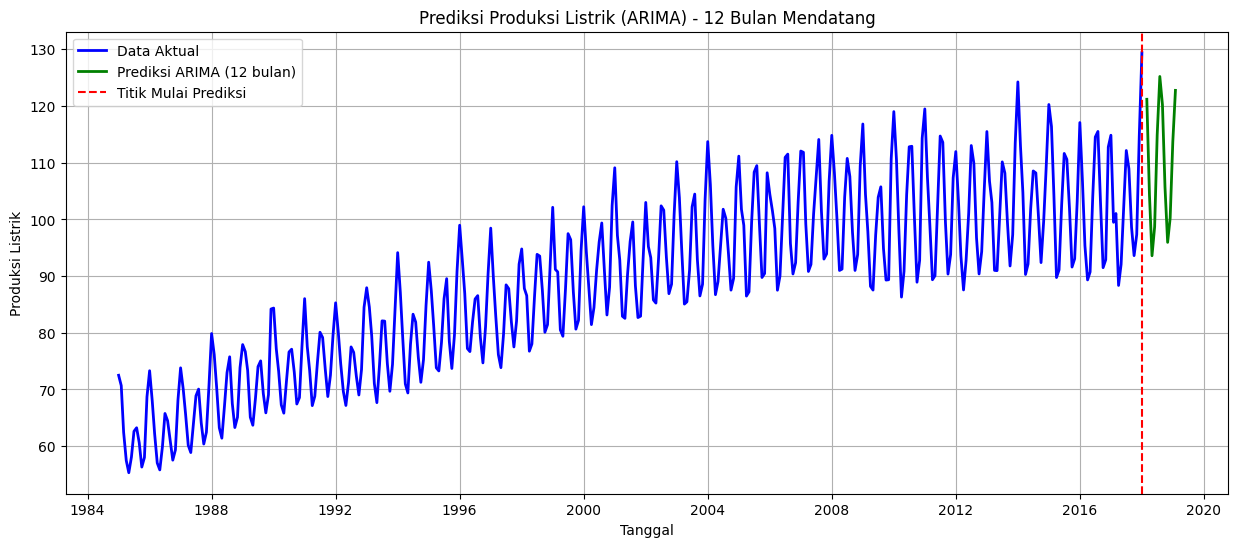

In [ ]:
# Plotting hasil prediksi ARIMA dan data aktual
plt.figure(figsize=(15, 6))

# Plot data aktual di sebelah kiri
plt.plot(df.index, df['IPG2211A2N'], label='Data Aktual', color='blue', linewidth=2)

# Plot prediksi ARIMA di sebelah kanan
plt.plot(future_dates_arima, forecast_arima, label='Prediksi ARIMA (12 bulan)', color='green', linewidth=2)

# Garis vertikal untuk menunjukkan transisi antara data aktual dan prediksi
plt.axvline(x=df.index[-1], color='red', linestyle='--', label='Titik Mulai Prediksi')

# Menambahkan judul, label, dan legenda
plt.title('Prediksi Produksi Listrik (ARIMA) - 12 Bulan Mendatang')
plt.xlabel('Tanggal')
plt.ylabel('Produksi Listrik')
plt.legend()
plt.grid()

# Menampilkan plot
plt.show()


In [ ]:
# Print metrik ARIMA
print("ARIMA Metrics:")
print("RMSE:", rmse_arima)
print("MSE:", mse_arima)
print("MAE:", mae_arima)
print("R^2 Score:", r2_arima)
print("MAPE:", mape_arima)

ARIMA Metrics:
RMSE: 9.67338389598849
MSE: 93.57435599916947
MAE: 7.829889863026248
R^2 Score: 0.2220137916374474
MAPE: 0.07615158880695883
